# Facial Keypoints Detection with PyTorch

Detecting key positions on face image is useful in several applications such as tracking face in image or video, analyzing facial expression, face recognition, and so on.We will use data provided by [Kaggle's Facial Keypoints Detection competition](https://www.kaggle.com/c/facial-keypoints-detection) and evaluate our predictions through it.

# Download data from Kaggle

The dataset can be downloaded from [Kaggle](https://www.kaggle.com/c/facial-keypoints-detection/data) or by using Kaggle API. You can find how to install Kaggle API [here](https://github.com/Kaggle/kaggle-api). Please be noted that, to download data and use the api, you must has Kaggle account and accept the term of the competition. To acquire your Kaggle API Token (kaggle.json) see [here](https://github.com/Kaggle/kaggle-api#api-credentials) for details.

In [0]:
# Install Kaggle API
!pip install -q kaggle



 Set Kaggle username and key (see your kaggle.json).

In [2]:
# fill in xxxx, see your kaggle.json
import os
os.environ['KAGGLE_USERNAME'] = "xxxxxx"
os.environ['KAGGLE_KEY'] = "xxxxxxxxxxxxxxx"

# download data from Kaggle
!kaggle competitions download -c facial-keypoints-detection -p data

 68% 41.0M/60.1M [00:00<00:00, 41.1MB/s]
100% 60.1M/60.1M [00:00<00:00, 88.1MB/s]
 56% 9.00M/16.0M [00:00<00:00, 16.9MB/s]
100% 16.0M/16.0M [00:00<00:00, 23.4MB/s]
  0% 0.00/201k [00:00<?, ?B/s]
100% 201k/201k [00:00<00:00, 169MB/s]
  0% 0.00/843k [00:00<?, ?B/s]
100% 843k/843k [00:00<00:00, 119MB/s]


Unzip the training and test datasets into data directory. 

In [3]:
# Unzip training and test datasets to data directory
!unzip data/training.zip -d data
!unzip data/test.zip -d data

Archive:  data/training.zip
  inflating: data/training.csv       
Archive:  data/test.zip
  inflating: data/test.csv           


The dataset consists of four files-*training.zip, test.zip, SampleSubmission.csv, and IdLookupTable.csv*. You can find more details [here](https://www.kaggle.com/c/facial-keypoints-detection/data)

# Explore Data

Download required dependencies.

In [0]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
%matplotlib inline

import torch
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import transforms, utils

from torch import nn, optim
import torch.nn.functional as F

import warnings
warnings.filterwarnings('ignore')

IMG_SIZE = 96

In [0]:
data_dir = Path('./data')
train_data = pd.read_csv(data_dir / 'training.csv')

In [6]:
# View train data
train_data.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,7009,7010,7011,7012,7013,7014,7015,7016,7017,7018,7019,7020,7021,7022,7023,7024,7025,7026,7027,7028,7029,7030,7031,7032,7033,7034,7035,7036,7037,7038,7039,7040,7041,7042,7043,7044,7045,7046,7047,7048
left_eye_center_x,66.0336,64.3329,65.0571,65.2257,66.7253,69.6807,64.1319,67.4689,65.8029,64.1212,65.2302,66.7376,66.5747,65.2706,66.6072,68.4913,66.6769,66.8504,67.8395,69.2335,65.5956,64.7625,66.0827,64.7186,66.3343,64.553,65.3184,65.4594,65.3769,72.3532,64.1556,64.9563,69.4418,67.5089,65.3781,66.0595,64.7125,66.215,67.0397,64.3325,...,66.6593,65.2627,66.3166,67.9037,66.4645,66.301,67.1193,64.8367,65.3903,62.3849,65.6084,61.9972,64.9061,67.0451,60.2021,72.2262,67.7241,63.0133,67.2779,65.84,69.4632,64.3929,67.3677,68.3209,66.162,66.6519,70.5049,71.2582,69.6162,64.6155,69.2299,63.353,65.7112,67.9293,66.8672,67.4025,66.1344,66.6907,70.9651,66.9383
left_eye_center_y,39.0023,34.9701,34.9096,37.2618,39.6213,39.9687,34.29,39.4135,34.7552,36.7403,34.3426,39.8864,37.308,34.9402,38.9381,35.9002,33.9412,35.637,38.5979,40.0215,36.6264,34.9334,37.1537,35.8612,33.7213,36.5242,35.2704,38.9086,38.1289,34.4171,35.2538,35.2355,37.8516,35.7277,35.632,36.8486,34.2681,35.6378,32.372,34.6073,...,40.0731,36.2124,43.8757,41.7278,37.9797,35.7512,37.9044,35.2976,32.2801,32.2983,37.6214,37.2758,41.8102,41.7374,37.7435,40.0464,38.876,36.0536,37.3832,39.1238,41.0387,38.2252,38.0488,36.8326,35.9309,37.3327,35.7834,39.7446,38.0495,35.1653,38.5756,35.6713,38.8435,35.8466,37.3569,31.8426,38.3655,36.8452,39.8537,43.4245
right_eye_center_x,30.227,29.9493,30.9038,32.0231,32.2448,29.1836,29.579,29.356,27.4758,29.4689,28.8027,30.2704,30.4453,33.0227,28.5962,27.8312,30.7136,32.5281,28.0167,25.5508,31.5408,31.8597,27.9783,31.5907,29.0771,32.2198,30.3096,32.0514,29.2155,28.6554,30.7579,29.1167,28.6935,30.6683,30.191,26.5891,30.8571,30.4626,27.1397,32.8899,...,31.0751,29.3557,28.1583,34.0728,30.0619,30.8998,33.7967,31.2624,28.2914,32.7659,31.2643,31.4254,30.5803,29.8587,38.6491,33.0462,29.3992,28.7469,29.1766,29.494,33.8927,29.21,28.6823,29.1977,33.1005,29.2966,32.1823,33.4652,29.494,26.7072,29.4079,33.9521,32.2688,28.6878,30.7509,29.7467,30.4786,31.6664,30.5433,31.0961
right_eye_center_y,36.4217,33.4487,34.9096,37.2618,38.042,37.5634,33.138,39.6217,36.1856,38.3902,33.9378,38.8144,37.308,32.9769,36.3032,37.0221,36.1495,36.5246,36.3977,38.0719,39.3078,37.1915,37.436,39.1194,34.0977,38.0786,38.7026,39.2602,39.5589,32.828,35.2538,35.2355,35.6967,33.6292,34.3974,37.7069,32.2253,37.5031,32.372,37.2519,...,35.5442,42.2983,37.3487,38.4538,39.0829,36.8461,38.2101,40.0939,36.1694,40.8549,38.459,37.9127,36.566,38.177,37.4441,37.8698,37.9297,38.0497,40.6963,42.3241,41.8064,38.6517,37.8144,37.5662,34.9929,37.8341,39.0827,36.6878,42.5967,39.8279,38.3455,40.8164,37.706,41.4525,40.1157,38.6329,39.9502,39.685,40.7723,39.5286
left_eye_inner_corner_x,59.5821,58.8562,59.412,60.0033,58.5659,62.8643,57.7972,59.555,58.6522,58.6209,58.7538,61.0176,59.0362,60.5032,61.7145,62.3222,60.3671,61.2288,60.1393,60.2627,59.1474,59.9242,59.8731,59.2879,59.9368,58.4007,60.1705,59.8324,58.4306,63.8785,57.2384,59.201,62.585,61.2136,59.5131,60.0528,58.8754,59.9972,60.3898,59.6305,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
left_eye_inner_corner_y,39.6474,35.2743,36.321,39.1272,39.6213,40.1693,35.154,40.4548,37.3293,37.8406,35.5571,39.8864,38.2768,34.9402,38.9381,36.1807,35.2031,36.5246,39.698,40.0215,37.9068,35.9011,38.2828,37.762,34.8497,37.5387,36.2995,39.6119,39.3545,34.9467,36.1483,36.5438,38.2435,36.8932,36.558,37.7069,34.8519,36.5704,33.2301,35.4888,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
left_eye_outer_corner_x,73.1303,70.7227,70.9844,72.3147,72.51

There are 7,049 images in training data. The input image, in the last field of data, consists of pixels as integers in (0-255).  The images are 96x96 pixels. The labels or targets are cordinates (x, y) of 15 keypoints:

*   Eyes: left_eye_center, right_eye_center, left_eye_inner_corner, left_eye_outer_corner, right_eye_inner_corner, right_eye_outer_corner
*   Eyebrows: left_eyebrow_inner, left_eyebrow_outer, right_eyebrow_inner, right_eyebrow_outer
*   Nose and Mouth: nose_tip, mouth_left_corner, mouth_right_corner, mouth_center_top, mouth_center_bottom.

As you can see, there are missing labels in train data.  There are only 2,140 images with all 15 keypoints .   We will consider how to work with them later.

In [7]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7049 entries, 0 to 7048
Data columns (total 31 columns):
left_eye_center_x            7039 non-null float64
left_eye_center_y            7039 non-null float64
right_eye_center_x           7036 non-null float64
right_eye_center_y           7036 non-null float64
left_eye_inner_corner_x      2271 non-null float64
left_eye_inner_corner_y      2271 non-null float64
left_eye_outer_corner_x      2267 non-null float64
left_eye_outer_corner_y      2267 non-null float64
right_eye_inner_corner_x     2268 non-null float64
right_eye_inner_corner_y     2268 non-null float64
right_eye_outer_corner_x     2268 non-null float64
right_eye_outer_corner_y     2268 non-null float64
left_eyebrow_inner_end_x     2270 non-null float64
left_eyebrow_inner_end_y     2270 non-null float64
left_eyebrow_outer_end_x     2225 non-null float64
left_eyebrow_outer_end_y     2225 non-null float64
right_eyebrow_inner_end_x    2270 non-null float64
right_eyebrow_inner_end_y 

We create helper functions, `show_keypoints()` to show keyponts on image and `show_images()` to display images from pandas dataframes having or not having keypoints.

In [0]:
def show_keypoints(image, keypoints):
    '''
    Show image with keypoints
    Args:
        image (array-like or PIL image): The image data. (M, N)
        keypoints (array-like): The keypoits data. (N, 2)
    '''
      
    plt.imshow(image, cmap='gray')
    if len(keypoints):
        plt.scatter(keypoints[:, 0], keypoints[:, 1], s=24, marker ='.', c='r')

In [0]:
def show_images(df, indxs, ncols=5, figsize=(15,10), with_keypoints=True):
    '''
    Show images with keypoints in grids
    Args:
        df (DataFrame): data (M x N)
        idxs (iterators): list, Range, Indexes
        ncols (integer): number of columns (images by rows)
        figsize (float, float): width, height in inches
        with_keypoints (boolean): True if show image with keypoints
    '''
    plt.figure(figsize=figsize)
    nrows = len(indxs) // ncols + 1
    for i, idx in enumerate(indxs):
        image = np.fromstring(df.loc[idx, 'Image'], sep=' ').astype(np.float32).reshape(-1, IMG_SIZE)
        if with_keypoints:
            keypoints = df.loc[idx].drop('Image').values.astype(np.float32).reshape(-1, 2)
        else:
            keypoints = []
        plt.subplot(nrows, ncols, i + 1)
        plt.title(f'Sample #{idx}')
        plt.axis('off')
        plt.tight_layout()
        show_keypoints(image, keypoints)
    plt.show()

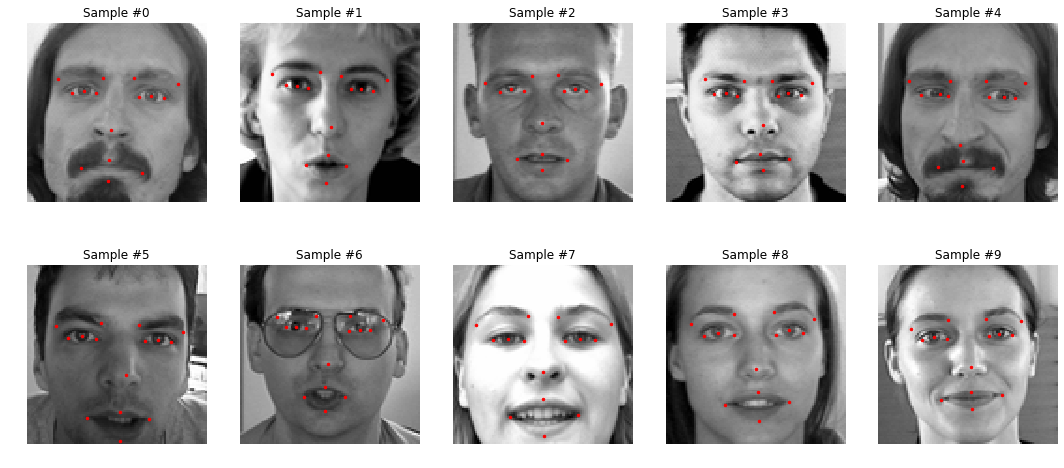

In [10]:
# View train images
show_images(train_data, range(10))

## How does our missing train data look like?

Let's randomly see how missing-keypoint samples look like.

In [11]:
# Explore missing-any-data
# missing_any_data = train_data.drop(train_data.dropna().index)
missing_any_data = train_data[train_data.isnull().any(axis=1)]
missing_any_data.T.tail(10)

,210,350,499,512,810,839,895,1058,1194,1230,1245,1546,1548,1585,1588,1598,1601,1605,1620,1624,1626,1627,1629,1636,1643,1646,1647,1652,1654,1678,1679,1684,1685,1687,1693,1703,1708,1717,1719,1721,...,7009,7010,7011,7012,7013,7014,7015,7016,7017,7018,7019,7020,7021,7022,7023,7024,7025,7026,7027,7028,7029,7030,7031,7032,7033,7034,7035,7036,7037,7038,7039,7040,7041,7042,7043,7044,7045,7046,7047,7048
nose_tip_y,61.2787,62.1639,58.1808,59.5908,57.7843,65.5464,59.7368,63.2299,64.6277,73.573,62.8202,66.0615,68.0685,55.3465,59.0138,60.9704,62.8043,61.9981,55.6728,60.626,57.8225,64.2684,62.726,51.0914,64.1229,60.0399,55.6057,57.6541,54.6764,52.7316,62.0046,57.0419,59.5204,55.501,55.2619,58.2074,60.4316,59.9254,57.5389,60.3862,...,59.4826,65.1205,74.5028,70.1023,63.719,63.4882,63.8899,65.1823,61.301,59.9427,63.5889,65.6185,67.5546,67.847,61.3917,64.7154,69.1574,61.6702,62.784,66.5548,65.8613,66.798,66.887,64.9524,65.9441,66.4145,65.9847,63.3652,70.4148,64.9649,70.8015,59.682,64.096,69.7491,64.9457,67.0291,66.626,67.5152,66.725,73.0333
mouth_left_corner_x,57.8848,57.029,56.9185,64.7701,65.1619,65.8893,62.9833,57.488,66.7683,62.7577,71.4979,70.4921,73.66,68.0135,62.3398,68.8035,65.8804,68.0391,NaN,62.1584,65.9387,62.8782,70.5604,62.6905,61.315,67.9271,60.8548,42.0737,60.9103,76.3099,61.4664,65.4598,66.7477,54.5959,59.6869,63.551,66.4509,59.8181,52.3401,53.5833,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mouth_left_corner_y,87.4592,86.7783,85.4828,82.8008,83.2227,86.8986,85.9832,86.9412,82.6614,94.3122,81.4839,83.7682,87.2296,71.1333,71.3081,77.111,75.8919,77.1093,NaN,74.2056,85.6152,79.7919,70.832,71.5689,75.7981,78.5186,80.3976,70.4579,70.7232,74.5669,79.9678,76.5339,81.9678,74.5119,85.5829,73.9371,77.9635,79.7718,74.854,76.7137,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mouth_right_corner_x,34.2931,36.251,28.1978,33.8235,28.7133,27.7611,34.2133,30.7513,21.903,29.3806,25.4452,30.042,31.7304,36.0251,28.4954,30.302,23.6615,32.0946,NaN,27.715,35.4105,26.4346,33.2615,30.8713,29.6731,22.4503,27.0167,19.2974,18.1799,35.1055,31.6909,33.2759,32.1279,24.1187,22.2798,35.7966,32.6617,31.1959,32.2279,44.0719,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mouth_right_corner_y,85.1578,87.0976,81.9372,82.449,82.4632,88.0423,85.4784,86.32,79.9367,92.6919,78.4135,84.8145,86.3279,79.185,69.7036,77.0383,76.4393,75.6255,NaN,69.5625,85.8783,80.4008,83.7525,71.0422,74.024,76.0963,70.4855,67.6561,60.4037,81.5812,79.0548,75.0127,84.4516,68.6528,75.9246,76.0728,77.4094,79.755,69.9045,77.3135,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mouth_center_top_lip_x,46.377,45.2018,45.9269,48.2416,47.4206,48.3502,48.3462,45.6744,44.3935,44.9351,47.8594,49.9309,52.695,54.6252,47.0863,50.2744,45.5546,46.1798,29.3244,46.7387,53.7274,46.1788,58.6578,45.9479,44.6241,45.1294,38.0802,26.0566,41.002,60.5872,45.5516,49.2965,50.4125,39.1363,43.9037,49.956,49.6941,44.5835,38.867,48.7204,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mouth_center_top_lip_y,79.1162,79.1061,75.5544,71.5475,77.7858,85.3734,77.1501,81.6563,78.7847,89.1275,75.5729,80.3618,84.9753,75.5648,73.7042,79.4052,79.6486,78.4677,66.6985,74.4801,83.6414,83.7266,78.0837,71.3714,77.9335,75.9538,75.2707,71.4196,67.4905,73.1437,79.6565,75.2028,81.9776,71.4872,82.0135,74.3834,77.184,79.2264,72.4388,77.999,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

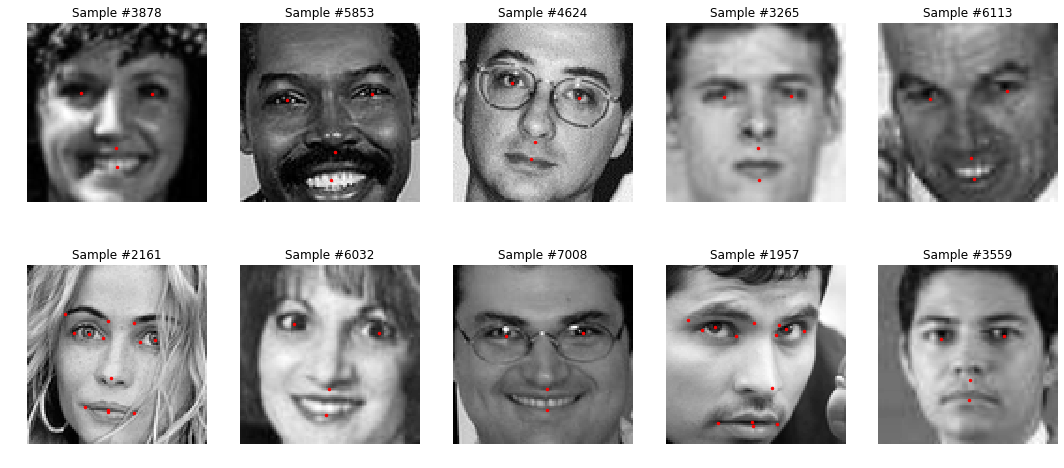

In [12]:
# View random missing-any-data images
idxs = missing_any_data.index
idxs = np.random.choice(idxs, 10)
show_images(train_data, idxs)

In [13]:
# Explore missing-bottom-lip-only data
missing_bottom_lip_only = train_data[(train_data.mouth_center_bottom_lip_x.isnull() & train_data.mouth_center_top_lip_x.notnull())]
missing_bottom_lip_only.T.tail(10)

,210,350,499,512,810,839,895,1058,1194,1230,1245,1546,1548,2199
nose_tip_y,61.2787,62.1639,58.1808,59.5908,57.7843,65.5464,59.7368,63.2299,64.6277,73.573,62.8202,66.0615,68.0685,74.8911
mouth_left_corner_x,57.8848,57.029,56.9185,64.7701,65.1619,65.8893,62.9833,57.488,66.7683,62.7577,71.4979,70.4921,73.66,83.3142
mouth_left_corner_y,87.4592,86.7783,85.4828,82.8008,83.2227,86.8986,85.9832,86.9412,82.6614,94.3122,81.4839,83.7682,87.2296,93.8066
mouth_right_corner_x,34.2931,36.251,28.1978,33.8235,28.7133,27.7611,34.2133,30.7513,21.903,29.3806,25.4452,30.042,31.7304,44.2838
mouth_right_corner_y,85.1578,87.0976,81.9372,82.449,82.4632,88.0423,85.4784,86.32,79.9367,92.6919,78.4135,84.8145,86.3279,95.5107
mouth_center_top_lip_x,46.377,45.2018,45.9269,48.2416,47.4206,48.3502,48.3462,45.6744,44.3935,44.9351,47.8594,49.9309,52.695,67.7019
mouth_center_top_lip_y,79.1162,79.1061,75.5544,71.5475,77.7858,85.3734,77.1501,81.6563,78.7847,89.1275,75.5729,80.3618,84.9753,94.5484
mouth_center_bottom_lip_x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mouth_center_bottom_lip_y,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Image,181 56 47 59 65 71 86 66 32 22 17 7 8 12 13 14...,59 41 36 32 32 31 33 41 55 72 79 70 64 50 52 6...,118 127 122 109 129 154 158 148 147 152 136 13...,194 194 194 191 194 191 191 183 166 151 126 86...,124 124 126 128 131 134 136 141 141 139 138 14...,33 28 25 30 46 67 64 92 169 175 175 183 189 18...,53 59 64 72 85 84 78 81 84 90 96 82 79 95 119 ...,79 85 87 89 88 87 87 51 16 18 17 14 8 5 10 13 ...,255 255 255 255 255 255 254 255 255 150 49 47 ...,254 250 190 99 52 41 38 37 36 32 29 28 28 30 2...,31 31 29 29 30 29 26 28 30 28 32 34 33 33 30 2...,49 54 49 40 35 38 37 33 32 32 41 42 41 38 34 3...,255 254 255 163 74 73 63 54 53 51 44 42 40 35 ...,26 26 33 30 22 25 21 20 18 20 40 54 44 33 33 4...


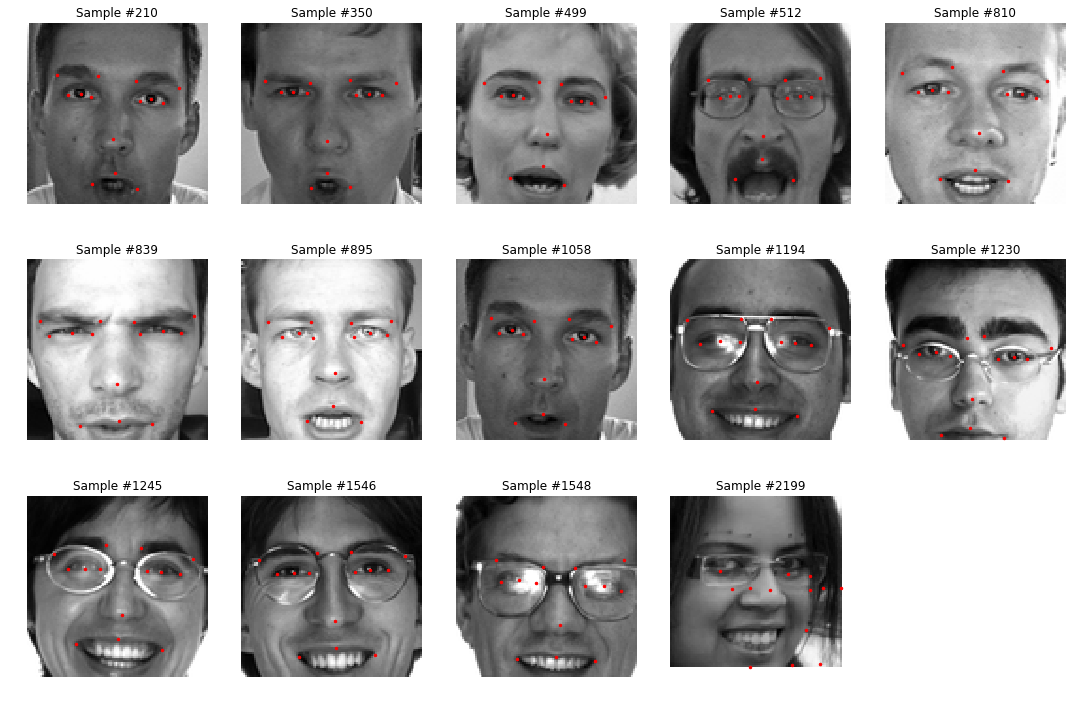

In [14]:
# View missing-bottom-lip-only images
idxs = missing_bottom_lip_only.index
show_images(train_data, idxs)

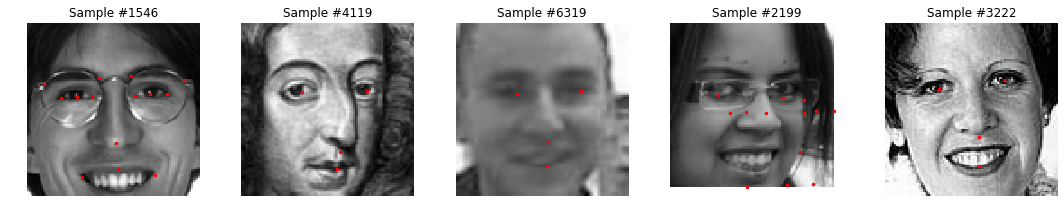

In [15]:
show_images(train_data, [1546, 4119, 6319, 2199, 3222])

As you can see, besides missing-keypoint, there are blur (#6319), cropped (#1546), and even missed-annotated sample (#2199). If we want to use these samples, we need to decide how to handle missing data and take into account of these diverse-quality samples.

## Test data

For test data, there're 1,783 images with only two field-ImageId and Image.

In [16]:
test_data = pd.read_csv(data_dir / 'test.csv')
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1783 entries, 0 to 1782
Data columns (total 2 columns):
ImageId    1783 non-null int64
Image      1783 non-null object
dtypes: int64(1), object(1)
memory usage: 27.9+ KB


In [17]:
test_data.head()

,ImageId,Image
0,1,182 183 182 182 180 180 176 169 156 137 124 10...
1,2,76 87 81 72 65 59 64 76 69 42 31 38 49 58 58 4...
2,3,177 176 174 170 169 169 168 166 166 166 161 14...
3,4,176 174 174 175 174 174 176 176 175 171 165 15...
4,5,50 47 44 101 144 149 120 58 48 42 35 35 37 39 ...


# Base case: drop missing data

We will begin with the samples having all 15 keypoints as base case. There're 2,140 samples having all keypoints in training data. We will use this dataset as our base case.

In [18]:
train_df = train_data.dropna()
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2140 entries, 0 to 2283
Data columns (total 31 columns):
left_eye_center_x            2140 non-null float64
left_eye_center_y            2140 non-null float64
right_eye_center_x           2140 non-null float64
right_eye_center_y           2140 non-null float64
left_eye_inner_corner_x      2140 non-null float64
left_eye_inner_corner_y      2140 non-null float64
left_eye_outer_corner_x      2140 non-null float64
left_eye_outer_corner_y      2140 non-null float64
right_eye_inner_corner_x     2140 non-null float64
right_eye_inner_corner_y     2140 non-null float64
right_eye_outer_corner_x     2140 non-null float64
right_eye_outer_corner_y     2140 non-null float64
left_eyebrow_inner_end_x     2140 non-null float64
left_eyebrow_inner_end_y     2140 non-null float64
left_eyebrow_outer_end_x     2140 non-null float64
left_eyebrow_outer_end_y     2140 non-null float64
right_eyebrow_inner_end_x    2140 non-null float64
right_eyebrow_inner_end_y 

# Preprocessing Data

One important process in data science pipeline is data preprocessing. PyTorch provides `Dataset` and `DataLoader` classes to make it easy and, hopefully, to make your code more readable.

## Dataset and DataLoader

`Dataset` allows you incorporate data preprocessing process through callable classes and `DataLoader` makes it easy to manage how data be feed into model more conveniently and efficiently.

## Create FaceKeypointsDataset

Create `FaceKeypointsDataset` as a subclass of `torch.utils.data.Dataset` and override `__len__` method to support `len(dataset)` and `__getitem__` method to support `dataset[i]` for data interation which's not stored all data in memory at once but read as required.

Sample of our dataset will be a `dict {'image': image, 'keypoints': keypoints}`. Our dataset will take an optional argument `transform` so that any required processing can be applied on the sample.

In [0]:
class FaceKeypointsDataset(Dataset):
    '''Face Keypoints Dataset'''
    
    def __init__(self, dataframe, train=True, transform=None):
        '''
        Args:
            dataframe (DataFrame): data in pandas dataframe format.
            train (Boolean) : True for train data with keypoints, default is True
            transform (callable, optional): Optional transform to be applied on 
            sample
        '''
        self.dataframe = dataframe
        self.train = train
        self.transform = transform
        
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        image = np.fromstring(self.dataframe.iloc[idx, -1], sep=' ')\
                .astype(np.float32).reshape(-1, IMG_SIZE)
        
        if self.train:
            keypoints = self.dataframe.iloc[idx, :-1].values.astype(np.float32)
        else:
            keypoints = None

        sample = {'image': image, 'keypoints': keypoints}
        
        
        if self.transform:
            sample = self.transform(sample)
            
        return sample

## Transforms

Before feeding into the model, numpy-array images need to be normalized and converted to Tensor. We will create transform as callable classes named Normalize and ToTensor.

In [0]:
class Normalize(object):
    '''Normalize input images'''
    
    def __call__(self, sample):
        image, keypoints = sample['image'], sample['keypoints']
        
        return {'image': image / 255., # scale to [0, 1]
                'keypoints': keypoints}
        
class ToTensor(object):
    '''Convert ndarrays in sample to Tensors.'''

    def __call__(self, sample):
        image, keypoints = sample['image'], sample['keypoints']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.reshape(1, IMG_SIZE, IMG_SIZE)
        image = torch.from_numpy(image)
        
        if keypoints is not None:
            keypoints = torch.from_numpy(keypoints)
            return {'image': image, 'keypoints': keypoints}
        else:
            return {'image': image}

## Split training data into train and validation sets

In [0]:
from torch.utils.data.sampler import SubsetRandomSampler

def prepare_train_valid_loaders(trainset, valid_size=0.2, 
                                batch_size=128):
    '''
    Split trainset data and prepare DataLoader for training and validation
    
    Args:
        trainset (Dataset): data 
        valid_size (float): validation size, defalut=0.2
        batch_size (int) : batch size, default=128
    ''' 
    
    # obtain training indices that will be used for validation
    num_train = len(trainset)
    indices = list(range(num_train))
    np.random.shuffle(indices)
    split = int(np.floor(valid_size * num_train))
    train_idx, valid_idx = indices[split:], indices[:split]
    
    # define samplers for obtaining training and validation batches
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)
    
    # prepare data loaders
    train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                               sampler=train_sampler)
    valid_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                               sampler=valid_sampler)
    
    return train_loader, valid_loader

## Filter out any missing data records

Now we're ready to create `Dataset` and `DataLoader` for training, validation and test as well. We also compose `Normalize` and `ToTensor` transforms by using `torchvision.transforms.Compose`

In [0]:
# drop any-missing-keypoint records
train_df = train_data.dropna()
test_df = test_data

# how many samples per batch to load
batch_size = 128
# percentage of training set to use as validation
valid_size = 0.2

# Define a transform to normalize the data
tsfm = transforms.Compose([Normalize(), ToTensor()])

# Load the training data and test data
trainset = FaceKeypointsDataset(train_df, transform=tsfm)
testset = FaceKeypointsDataset(test_df, train=False, transform=tsfm)

# prepare data loaders
train_loader, valid_loader = prepare_train_valid_loaders(trainset, 
                                                         valid_size,
                                                         batch_size)

test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size)

# MLP Model

For base case, let's try Multi-Layer Perceptrons (MLP). In PyTorch, we can construct neural network model by subclass nn.Module and define __init__ and forward methods. Our MLP will consist of hidden layers and output layer. Each hidden layer will consist of fully-connected layer with activation function and dropout layer.

Our model will have input size 9,216 (96 * 96) and two fully-connected layers, 128 and 64 units each, with ReLu activation and dropout with probability 0.1. The output size is 30 which is the number of total keypoints in x and y.

In [0]:
from torch import nn, optim
import torch.nn.functional as F

class MLP(nn.Module):
    def __init__(self, input_size, output_size, hidden_layers, drop_p =0.5):
        
        '''
        Buid a forward network with arbitrary hidden layers.
        
        Arguments
            ---------
            input_size (integer): size of the input layer
            output_size (integer): size of the output layer
            hidden_layers (list of integers):, the sizes of each hidden layers
        '''
        
        super(MLP, self).__init__()
        
        # hidden layers
        layer_sizes = [(input_size, hidden_layers[0])] \
                      + list(zip(hidden_layers[:-1], hidden_layers[1:]))
        self.hidden_layers = nn.ModuleList([nn.Linear(h1, h2) 
                                            for h1, h2 in layer_sizes])
        
        self.output = nn.Linear(hidden_layers[-1], output_size)
        
        self.dropout = nn.Dropout(drop_p)
        
    def forward(self, x):
        ''' Forward pass through the network, returns the output logits '''
        # flatten inputs
        x = x.view(x.shape[0], -1)
        
        for layer in self.hidden_layers:
            x = F.relu(layer(x))
            x = self.dropout(x)
        x = self.output(x)    
        return x

In [0]:
model = MLP(input_size=IMG_SIZE*IMG_SIZE, output_size=30, 
            hidden_layers=[128, 64], drop_p=0.1)

# Train the network

In PyTorch, we can specify if the network will be trained on GPU or CPU by defining the device and set the model to it.

In [0]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

For the training, we need to specify objective loss function or criterion and optimizer. We will define Mean Square Errors (MSE) as criterion and Adam with learning rate (lr) equal 0.003 as optimizer.

In [0]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

For convenience, we will wrap up the training and validation processes by creating train function which will train, validate, save the minimum-validation-RMSE model,  and return the training and validation RMSEs by epoch.

In [0]:
def train(train_loader, valid_loader, model, criterion, optimizer, 
          n_epochs=50, saved_model='model.pt'):
    '''
    Train the model
    
    Args:
        train_loader (DataLoader): DataLoader for train Dataset
        valid_loader (DataLoader): DataLoader for valid Dataset
        model (nn.Module): model to be trained on
        criterion (torch.nn): loss funtion
        optimizer (torch.optim): optimization algorithms
        n_epochs (int): number of epochs to train the model
        saved_model (str): file path for saving model
    
    Return:
        tuple of train_losses, valid_losses
    '''

    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf # set initial "min" to infinity

    train_losses = []
    valid_losses = []

    for epoch in range(n_epochs):
        # monitor training loss
        train_loss = 0.0
        valid_loss = 0.0

        ###################
        # train the model #
        ###################
        model.train() # prep model for training
        for batch in train_loader:
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(batch['image'].to(device))
            # calculate the loss
            loss = criterion(output, batch['keypoints'].to(device))
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # update running training loss
            train_loss += loss.item()*batch['image'].size(0)

        ######################    
        # validate the model #
        ######################
        model.eval() # prep model for evaluation
        for batch in valid_loader:
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(batch['image'].to(device))
            # calculate the loss
            loss = criterion(output, batch['keypoints'].to(device))
            # update running validation loss 
            valid_loss += loss.item()*batch['image'].size(0)

        # print training/validation statistics 
        # calculate average Root Mean Square loss over an epoch
        train_loss = np.sqrt(train_loss/len(train_loader.sampler.indices))
        valid_loss = np.sqrt(valid_loss/len(valid_loader.sampler.indices))

        train_losses.append(train_loss)
        valid_losses.append(valid_loss)

        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'
              .format(epoch+1, train_loss, valid_loss))

        # save model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'
                  .format(valid_loss_min, valid_loss))
            torch.save(model.state_dict(), saved_model)
            valid_loss_min = valid_loss
            
    return train_losses, valid_losses  

Now, let's train the base case for 50 epochs and save the model as "model.pt"

In [28]:
train_losses, valid_losses = train(train_loader, valid_loader, model,
                                   criterion, optimizer, n_epochs=50, 
                                   saved_model='model.pt')

Epoch: 1 	Training Loss: 31.697235 	Validation Loss: 17.296636
Validation loss decreased (inf --> 17.296636).  Saving model ...
Epoch: 2 	Training Loss: 17.301782 	Validation Loss: 12.779532
Validation loss decreased (17.296636 --> 12.779532).  Saving model ...
Epoch: 3 	Training Loss: 14.991152 	Validation Loss: 12.378069
Validation loss decreased (12.779532 --> 12.378069).  Saving model ...
Epoch: 4 	Training Loss: 14.091430 	Validation Loss: 11.737113
Validation loss decreased (12.378069 --> 11.737113).  Saving model ...
Epoch: 5 	Training Loss: 13.648254 	Validation Loss: 11.328227
Validation loss decreased (11.737113 --> 11.328227).  Saving model ...
Epoch: 6 	Training Loss: 13.181695 	Validation Loss: 11.399375
Epoch: 7 	Training Loss: 12.918074 	Validation Loss: 10.747939
Validation loss decreased (11.328227 --> 10.747939).  Saving model ...
Epoch: 8 	Training Loss: 12.139989 	Validation Loss: 10.323615
Validation loss decreased (10.747939 --> 10.323615).  Saving model ...
Epoch

In [0]:
# Function to plot RMSE vs epochs
def plot_RMSE(train_losses, valid_losses, y_max=50):
    plt.plot(train_losses, "--", linewidth=3, label="train")
    plt.plot(valid_losses, linewidth=3, label="val")
    plt.legend()
    plt.grid()
    plt.xlabel('Epoch')
    plt.ylabel('RMSE')
    plt.ylim((0, y_max))
    plt.show()

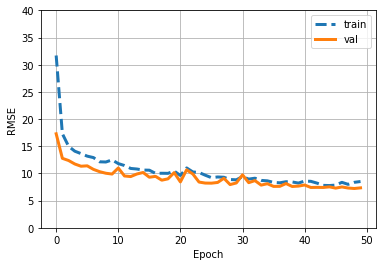

In [30]:
plot_RMSE(train_losses, valid_losses, y_max=40)

# View Predictions

We will provide two functions `predict` , to predict keypoints of images from specific model, and `view_pred_df`, to display keypoints from test dataframe.

In [0]:
def predict(data_loader, model):
    '''
    Predict keypoints
    Args:
        data_loader (DataLoader): DataLoader for Dataset
        model (nn.Module): trained model for prediction.
    Return:
        predictions (array-like): keypoints in float (no. of images x keypoints).
    '''
    
    model.eval() # prep model for evaluation

    with torch.no_grad():
        for i, batch in enumerate(data_loader):
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(batch['image'].to(device)).cpu().numpy()
            if i == 0:
                predictions = output
            else:
                predictions = np.vstack((predictions, output))
    
    return predictions

In [0]:
def view_pred_df(columns, test_df, predictions, image_ids=range(1,6)):
    '''
    Display predicted keypoints
    Args:
        columns (array-like): column names
        test_df (DataFrame): dataframe with ImageId and Image columns
        predictions (array-like): keypoints in float (no. of images x keypoints)
        image_id (array-like): list or range of ImageIds begin at 1
    '''
    pred_df = pd.DataFrame(predictions, columns=columns)
    pred_df = pd.concat([pred_df, test_df], axis=1)
    pred_df = pred_df.set_index('ImageId')
    show_images(pred_df, image_ids)  # ImageId as index begin at 1

Now, let's view how our model predict keypoints on test set images.

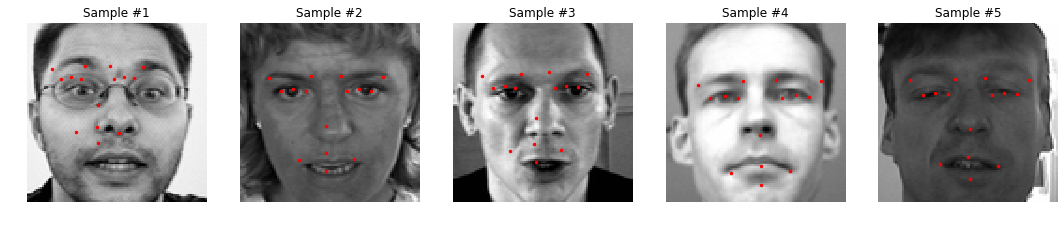

In [33]:
# Load the minimum valuation loss model
model.load_state_dict(torch.load('model.pt'))
predictions = predict(test_loader, model)
columns = train_df.drop('Image', axis=1).columns
view_pred_df(columns, test_df, predictions)

With validation loss about 7 and what we see on images, it seems our predictions are not effective enough. Let's see how would they score on Kaggle.

# Evaluation

To submit our predictions, we will use `create_submission` function to prepare the csv file as required by Kaggle for submission.

In [0]:
def create_submission(predictions, pred_file='data/preds.csv', sub_file='data/submission.csv', columns=None):
    '''
    Create csv file for submission from predictions
    Args:
        predictions (array-like): prediction (no. fo images x 30 keypoints)
        pred_file (string): file path for prediction csv file
        sub_file (string): file path for submission csv file
        columns (dict): provided column names for submission file
    '''
    lookup = pd.read_csv('data/IdLookupTable.csv')
    if columns == None:
        columns = train_data.columns[:-1]
    preds = pd.DataFrame(predictions, 
                         index=np.arange(1, len(predictions)+1), 
                         columns=columns)
    preds.to_csv(pred_file)
    locations = [preds.loc[image_id, feature_name] 
                 for image_id, feature_name 
                 in lookup[['ImageId', 'FeatureName']].values]
    locations = [location if location < IMG_SIZE else IMG_SIZE for location in locations]
    lookup.Location = pd.Series(locations)
    lookup[['RowId', 'Location']].to_csv(sub_file, index=False)

Now create submission.csv and submit to Kaggle

In [0]:
create_submission(predictions)

In [0]:
# Comment out to submit to Kaggle
#!kaggle competitions submit -c facial-keypoints-detection -f data/submission.csv -m "Base MLP"

In [37]:
submission = pd.read_csv('data/submission.csv')
submission.head()

,RowId,Location
0,1,51.399837
1,2,28.728537
2,3,23.418613
3,4,28.720478
4,5,45.989758


# Augmentation

Data augmentation can help increase amount of **relevant data** for training. Besides preparing data as we did, we can compose data augmentations using  `transform` object as well. For images, we can do many ways-flip, resize, crop, rotate, etc. Let's try randomly  flip image horizontally by create `RandomHorizontalFlip` transform.

In [0]:
class RandomHorizontalFlip(object):
    '''
    Horizontally flip image randomly with given probability
    Args:
        p (float): probability of the image being flipped.
                   Defalut value = 0.5
    '''
    
    def __init__(self, p=0.5):
        self.p = p

    def __call__(self, sample):
        
        flip_indices = [(0, 2), (1, 3),
                        (4, 8), (5, 9), (6, 10), (7, 11),
                        (12, 16), (13, 17), (14, 18), (15, 19),
                        (22, 24), (23, 25)]
        
        image, keypoints = sample['image'], sample['keypoints']
        
        if np.random.random() < self.p:
            image = image[:, ::-1]
            if keypoints is not None:
                for a, b in flip_indices:
                    keypoints[a], keypoints[b]= keypoints[b], keypoints[a]
                keypoints[::2] = 96. - keypoints[::2]
        
        return {'image': image, 
                'keypoints': keypoints}

## Let's see what augmented images look like.

In [0]:
aug_train_df = train_data.dropna()
aug_transform = transforms.Compose([RandomHorizontalFlip(p=1.0), 
                                    Normalize(),
                                    ToTensor()])
aug_trainset = FaceKeypointsDataset(aug_train_df, transform=aug_transform)

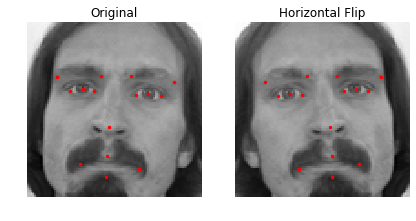

In [40]:
plt.subplot(1,2,1)
plt.title(f'Original')
plt.axis('off')
plt.tight_layout()
image = trainset[0]['image'].numpy().squeeze()
keypoints = trainset[0]['keypoints'].numpy().reshape(-1,2)
show_keypoints(image, keypoints)
plt.subplot(1,2,2)
plt.title(f'Horizontal Flip')
plt.axis('off')
plt.tight_layout()
image = aug_trainset[0]['image'].numpy().squeeze()
keypoints = aug_trainset[0]['keypoints'].numpy().reshape(-1,2)
show_keypoints(image, keypoints)

In [0]:
def show_dataset_images(dataset, n_images=10, n_cols=5, figsize=(15,10)):
    '''
    Show Dataset images with keypoints in grids
    Args:
        dataset (Dataset): data
        idxs (iterators): list, Range, Indexes
        ncols (integer): number of columns (images by rows)
        figsize (float, float): width, height in inches
        with_keypoints (boolean): True if data consists of keypoint data
    '''
        
    plt.figure(figsize=figsize)
    n_rows = n_images // n_cols + 1
    for idx in range(n_images):
        image = dataset[idx]['image'].numpy().squeeze()
        keypoints = dataset[idx]['keypoints'].numpy().reshape(-1,2)
        plt.subplot(n_rows, n_cols, idx+1)
        plt.grid(False)
        plt.tight_layout()
        show_keypoints(image, keypoints)

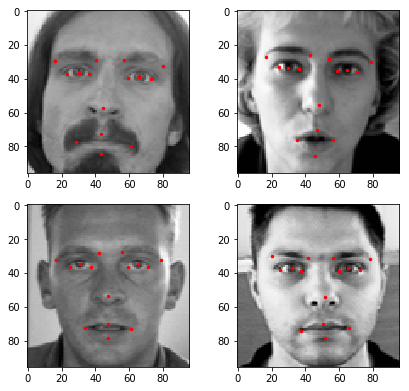

In [42]:
# Original 
show_dataset_images(trainset, 4, 2, (6,8))

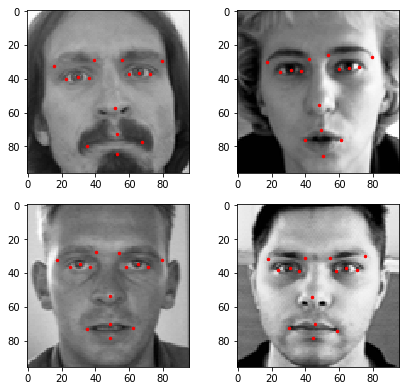

In [43]:
# Horizontal Flip
show_dataset_images(aug_trainset, 4, 2, (6,8))

## Prepared loaders with augmentation

All we need to do is just add `RandomHorizontalFlip` to transforms.compose and prepare `trainset`, `train_loader` and `valid_loader` as we did earlier.

In [0]:
# how many samples per batch to load
batch_size = 128
# percentage of training set to use as validation
valid_size = 0.2


# Drop missing data
aug_train_df = train_data.dropna()

# Define a transform to augment the data
aug_tfms = transforms.Compose([RandomHorizontalFlip(p=0.5),
                                    Normalize(),
                                    ToTensor()])

# Load the training data
aug_trainset = FaceKeypointsDataset(aug_train_df, transform=aug_tfms)


# prepare data loaders
aug_train_loader, aug_valid_loader = prepare_train_valid_loaders(aug_trainset, 
                                                                 valid_size,
                                                                 batch_size)

Let's run the training using same  MLP model, criterion, and optimizer for 50 epochs and save it to `aug_model.pt`

In [0]:
model = MLP(input_size=IMG_SIZE*IMG_SIZE, output_size=30, hidden_layers=[128, 64], drop_p=0.1)
model = model.to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

In [46]:
aug_train_losses, aug_valid_losses = train(aug_train_loader, aug_valid_loader, model, criterion, 
                                           optimizer, n_epochs=50, saved_model='aug_model.pt')

Epoch: 1 	Training Loss: 33.440923 	Validation Loss: 18.001935
Validation loss decreased (inf --> 18.001935).  Saving model ...
Epoch: 2 	Training Loss: 18.200156 	Validation Loss: 13.056369
Validation loss decreased (18.001935 --> 13.056369).  Saving model ...
Epoch: 3 	Training Loss: 15.607656 	Validation Loss: 12.691561
Validation loss decreased (13.056369 --> 12.691561).  Saving model ...
Epoch: 4 	Training Loss: 14.674131 	Validation Loss: 11.942310
Validation loss decreased (12.691561 --> 11.942310).  Saving model ...
Epoch: 5 	Training Loss: 14.040228 	Validation Loss: 11.817921
Validation loss decreased (11.942310 --> 11.817921).  Saving model ...
Epoch: 6 	Training Loss: 13.572279 	Validation Loss: 12.300301
Epoch: 7 	Training Loss: 13.322337 	Validation Loss: 11.607552
Validation loss decreased (11.817921 --> 11.607552).  Saving model ...
Epoch: 8 	Training Loss: 12.815847 	Validation Loss: 11.737517
Epoch: 9 	Training Loss: 12.760604 	Validation Loss: 10.960171
Validation lo

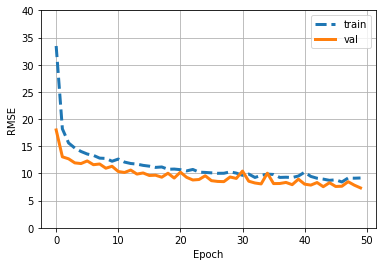

In [47]:
plot_RMSE(aug_train_losses, aug_valid_losses, y_max=40)

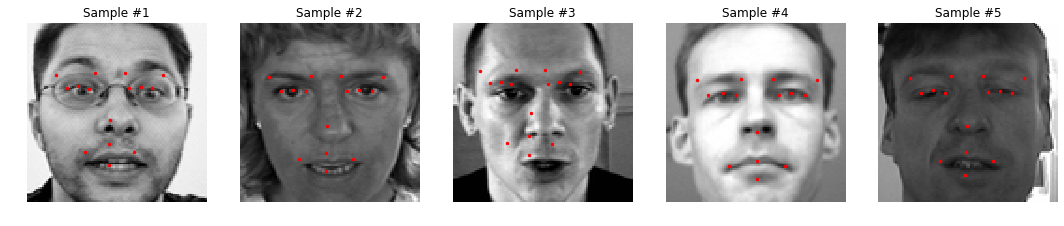

In [48]:
model.load_state_dict(torch.load('aug_model.pt'))
predictions = predict(test_loader, model)
columns = train_df.drop('Image', axis=1).columns
view_pred_df(columns, test_df, predictions)

In [0]:
create_submission(predictions, 
                  pred_file='data/aug_mlp_preds.csv', 
                  sub_file='data/aug_mlp_submission.csv')

In [0]:
# Comment out to submit to Kaggle
#!kaggle competitions submit -c facial-keypoints-detection -f data/aug_mlp_submission.csv -m "Augmented MLP"

# Convolutional Neural Network (CNN)

Next, we will try CNN model which is more suitable for image problems. Our CNN will have three  convolutional layers with ReLu activation and max-pooling layer each, followed by two 128-unit fully connected layers with dropout layer each. You can learn more about CNN[ here](http://cs231n.github.io/convolutional-networks/).

In [0]:
class CNN(nn.Module):
    '''
    Convolutional Neural Network model
            
    Args:
        ---------
        output_size (integer): size of the output layer
    '''
    
    def __init__(self, outputs=30):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64*12*12, 1024)
        self.fc2 = nn.Linear(1024, outputs)
        self.dropout = nn.Dropout(0.3)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 64*12*12)
        x = F.relu(self.fc1(self.dropout(x)))
        x = self.fc2(self.dropout(x))
        
        return x

Now let's train CNN model with augmented data.

In [0]:
model = CNN(outputs=30)
model = model.to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

In [53]:
aug_cnn_train_losses, aug_cnn_valid_losses = train(aug_train_loader, aug_valid_loader, model, criterion, 
                                                   optimizer, n_epochs=50, saved_model='aug_cnn.pt')

Epoch: 1 	Training Loss: 25.739638 	Validation Loss: 6.599896
Validation loss decreased (inf --> 6.599896).  Saving model ...
Epoch: 2 	Training Loss: 8.261805 	Validation Loss: 4.691586
Validation loss decreased (6.599896 --> 4.691586).  Saving model ...
Epoch: 3 	Training Loss: 5.243743 	Validation Loss: 3.650858
Validation loss decreased (4.691586 --> 3.650858).  Saving model ...
Epoch: 4 	Training Loss: 4.421575 	Validation Loss: 3.477738
Validation loss decreased (3.650858 --> 3.477738).  Saving model ...
Epoch: 5 	Training Loss: 4.147350 	Validation Loss: 3.345480
Validation loss decreased (3.477738 --> 3.345480).  Saving model ...
Epoch: 6 	Training Loss: 4.087290 	Validation Loss: 3.375021
Epoch: 7 	Training Loss: 3.957168 	Validation Loss: 3.253756
Validation loss decreased (3.345480 --> 3.253756).  Saving model ...
Epoch: 8 	Training Loss: 3.980228 	Validation Loss: 3.208952
Validation loss decreased (3.253756 --> 3.208952).  Saving model ...
Epoch: 9 	Training Loss: 3.954749

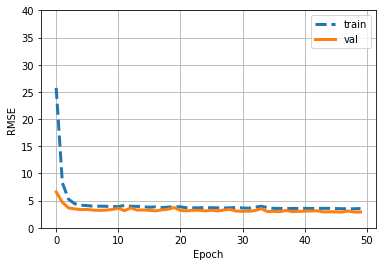

In [54]:
plot_RMSE(aug_cnn_train_losses, aug_cnn_valid_losses, y_max=40)

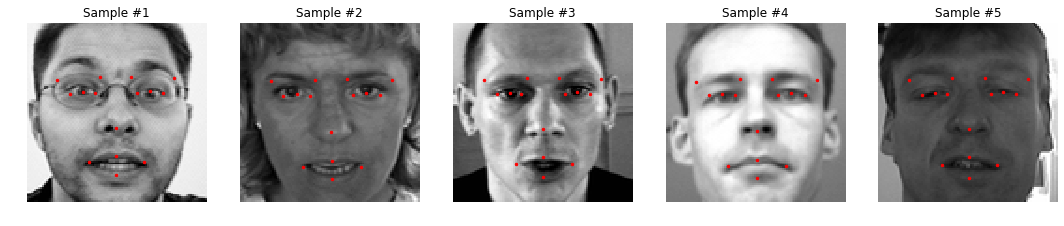

In [55]:
model.load_state_dict(torch.load('aug_cnn.pt'))

predictions = predict(test_loader, model)

create_submission(predictions, 
                  pred_file='data/aug_cnn_preds.csv', 
                  sub_file='data/aug_cnn_submission.csv')

view_pred_df(columns, test_df, predictions)

In [0]:
# Comment out to submit to Kaggle
#!kaggle competitions submit -c facial-keypoints-detection -f data/aug_cnn_submission.csv -m "Augmented CNN"

# 2 Models-2 Datasets

So far we just use 2,140 images from total 7,094 images in original training data. What's about the rest? If we look at our training data, we can see there're two groups of keypoints-one with about 2,000 samples and one with about 7,000 samples. To make uses of them, we will build separate models based on samples of each groups.

In [57]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7049 entries, 0 to 7048
Data columns (total 31 columns):
left_eye_center_x            7039 non-null float64
left_eye_center_y            7039 non-null float64
right_eye_center_x           7036 non-null float64
right_eye_center_y           7036 non-null float64
left_eye_inner_corner_x      2271 non-null float64
left_eye_inner_corner_y      2271 non-null float64
left_eye_outer_corner_x      2267 non-null float64
left_eye_outer_corner_y      2267 non-null float64
right_eye_inner_corner_x     2268 non-null float64
right_eye_inner_corner_y     2268 non-null float64
right_eye_outer_corner_x     2268 non-null float64
right_eye_outer_corner_y     2268 non-null float64
left_eyebrow_inner_end_x     2270 non-null float64
left_eyebrow_inner_end_y     2270 non-null float64
left_eyebrow_outer_end_x     2225 non-null float64
left_eyebrow_outer_end_y     2225 non-null float64
right_eyebrow_inner_end_x    2270 non-null float64
right_eyebrow_inner_end_y 

We will group samples into two groups, L (Large)-for the keypoints with about 7,000 samples and S (Small)-for the keypoints with about 2,000 samples. We will define this in datasets dictionary.

In [0]:
datasets = {'L': ['left_eye_center_x', 'left_eye_center_y',
                  'right_eye_center_x','right_eye_center_y',
                  'nose_tip_x', 'nose_tip_y',
                  'mouth_center_bottom_lip_x', 'mouth_center_bottom_lip_y',
                  'Image'
                 ], 
            'S': ['left_eye_inner_corner_x','left_eye_inner_corner_y', 
                  'left_eye_outer_corner_x', 'left_eye_outer_corner_y', 
                  'right_eye_inner_corner_x', 'right_eye_inner_corner_y', 
                  'right_eye_outer_corner_x', 'right_eye_outer_corner_y', 
                  'left_eyebrow_inner_end_x', 'left_eyebrow_inner_end_y', 
                  'left_eyebrow_outer_end_x', 'left_eyebrow_outer_end_y', 
                  'right_eyebrow_inner_end_x', 'right_eyebrow_inner_end_y', 
                  'right_eyebrow_outer_end_x', 'right_eyebrow_outer_end_y',
                  'mouth_left_corner_x', 'mouth_left_corner_y', 
                  'mouth_right_corner_x', 'mouth_right_corner_y', 
                  'mouth_center_top_lip_x', 'mouth_center_top_lip_y',
                  'Image'
                 ]
           }

## Tweak our RandomHorizontalFlip class

We need to modify our `RandomHorizontalFlip` to take dataset as an argument.

In [0]:
class RandomHorizontalFlip(object):
    '''
    Convert ndarrays in sample to Tensors.
    '''
    
    def __init__(self, p=0.5, dataset='A'):
        
        '''
        Args:
        p (float): probability of the image being flipped,
                   defalut value = 0.5
        dataset (string): A=All, L=dataset L, S=dataset S,
                   default value =  A
        '''
        self.p = p
        self.dataset = dataset

    def __call__(self, sample):
        
        if self.dataset == 'L':
            flip_indices = [(0, 2), (1, 3)]
        elif self.dataset == 'S':
            flip_indices = [(0, 4), (1, 5), (2, 6), (3, 7),
                            (8, 12), (9, 13), (10, 14), (11, 15),
                            (16, 18), (17, 19)]
        else:
            flip_indices = [(0, 2), (1, 3),
                            (4, 8), (5, 9), (6, 10), (7, 11),
                            (12, 16), (13, 17), (14, 18), (15, 19),
                            (22, 24), (23, 25)]
        
        image, keypoints = sample['image'], sample['keypoints']
        
        if np.random.random() < self.p:
            image = image[:, ::-1]
            if keypoints is not None:
                for a, b in flip_indices:
                    keypoints[a], keypoints[b]= keypoints[b], keypoints[a]
                keypoints[::2] = 96. - keypoints[::2]
        
        return {'image': image, 
                'keypoints': keypoints}

## L Model

Now, let's select L dataset (7,000 samples), preprocess data, create model, define criterion and optimizer, train the model, and view predictions.

In [60]:
# Select L data
L_aug_df = train_data[datasets['L']].dropna()

L_aug_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7000 entries, 0 to 7048
Data columns (total 9 columns):
left_eye_center_x            7000 non-null float64
left_eye_center_y            7000 non-null float64
right_eye_center_x           7000 non-null float64
right_eye_center_y           7000 non-null float64
nose_tip_x                   7000 non-null float64
nose_tip_y                   7000 non-null float64
mouth_center_bottom_lip_x    7000 non-null float64
mouth_center_bottom_lip_y    7000 non-null float64
Image                        7000 non-null object
dtypes: float64(8), object(1)
memory usage: 546.9+ KB


In [0]:
# Define a transform to augment and normalize data
L_aug_tfms = transforms.Compose([RandomHorizontalFlip(p=0.5, dataset='L'),
                                 Normalize(), ToTensor()])

# Load the training data
L_aug_trainset = FaceKeypointsDataset(L_aug_df, transform=L_aug_tfms)


# prepare data loaders
L_aug_train_loader, L_aug_valid_loader = prepare_train_valid_loaders(L_aug_trainset, 
                                                                     valid_size,
                                                                     batch_size)

In [0]:
outputs = len(datasets['L']) - 1
model = CNN(outputs)
model = model.to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

In [66]:
L_train_losses, L_valid_losses = train(L_aug_train_loader, L_aug_valid_loader, 
                                   model, criterion, optimizer, 
                                   n_epochs=50, saved_model='L_aug_cnn.pt')

Epoch: 1 	Training Loss: 20.048998 	Validation Loss: 5.638309
Validation loss decreased (inf --> 5.638309).  Saving model ...
Epoch: 2 	Training Loss: 5.268418 	Validation Loss: 4.102299
Validation loss decreased (5.638309 --> 4.102299).  Saving model ...
Epoch: 3 	Training Loss: 4.890872 	Validation Loss: 4.136968
Epoch: 4 	Training Loss: 4.843718 	Validation Loss: 4.018443
Validation loss decreased (4.102299 --> 4.018443).  Saving model ...
Epoch: 5 	Training Loss: 4.762360 	Validation Loss: 3.949028
Validation loss decreased (4.018443 --> 3.949028).  Saving model ...
Epoch: 6 	Training Loss: 4.788540 	Validation Loss: 4.323500
Epoch: 7 	Training Loss: 4.786390 	Validation Loss: 4.101479
Epoch: 8 	Training Loss: 4.708105 	Validation Loss: 4.055304
Epoch: 9 	Training Loss: 4.681974 	Validation Loss: 4.119304
Epoch: 10 	Training Loss: 4.643463 	Validation Loss: 3.949872
Epoch: 11 	Training Loss: 4.624222 	Validation Loss: 3.922458
Validation loss decreased (3.949028 --> 3.922458).  Sav

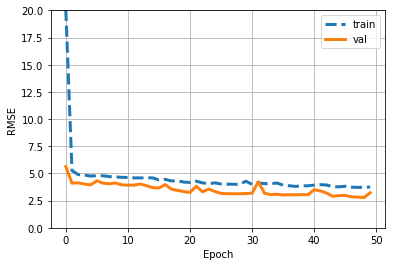

In [67]:
plot_RMSE(L_train_losses, L_valid_losses, y_max=20)

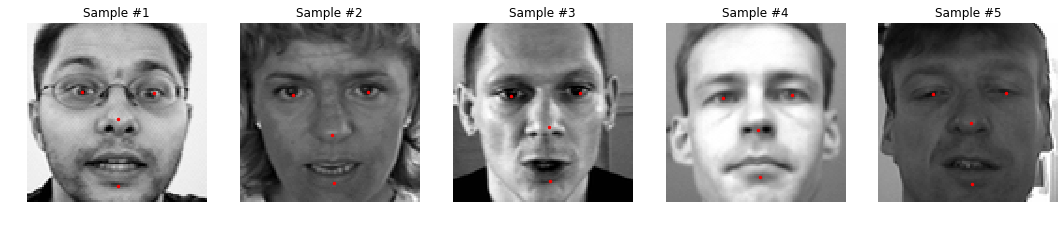

In [68]:
model.load_state_dict(torch.load('L_aug_cnn.pt'))

L_predictions = predict(test_loader, model)

L_columns = L_aug_df.drop('Image', axis=1).columns

view_pred_df(L_columns, test_df, L_predictions)

## S Model

S dataset have 2,155 non-missing samples

In [69]:
# Select S data
S_aug_df = train_data[datasets['S']].dropna()
S_aug_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2155 entries, 0 to 2283
Data columns (total 23 columns):
left_eye_inner_corner_x      2155 non-null float64
left_eye_inner_corner_y      2155 non-null float64
left_eye_outer_corner_x      2155 non-null float64
left_eye_outer_corner_y      2155 non-null float64
right_eye_inner_corner_x     2155 non-null float64
right_eye_inner_corner_y     2155 non-null float64
right_eye_outer_corner_x     2155 non-null float64
right_eye_outer_corner_y     2155 non-null float64
left_eyebrow_inner_end_x     2155 non-null float64
left_eyebrow_inner_end_y     2155 non-null float64
left_eyebrow_outer_end_x     2155 non-null float64
left_eyebrow_outer_end_y     2155 non-null float64
right_eyebrow_inner_end_x    2155 non-null float64
right_eyebrow_inner_end_y    2155 non-null float64
right_eyebrow_outer_end_x    2155 non-null float64
right_eyebrow_outer_end_y    2155 non-null float64
mouth_left_corner_x          2155 non-null float64
mouth_left_corner_y       

In [0]:
# Define a transform to augment and normalize data
S_aug_tfms = transforms.Compose([RandomHorizontalFlip(p=0.5, dataset='S'),
                                 Normalize(), ToTensor()])

# Create dataset
S_aug_trainset = FaceKeypointsDataset(S_aug_df, transform=S_aug_tfms)


# prepare data loaders
S_aug_train_loader, S_aug_valid_loader = prepare_train_valid_loaders(S_aug_trainset, 
                                                                     valid_size,
                                                                     batch_size)

In [0]:
outputs = len(datasets['S']) - 1
model = CNN(outputs)
model = model.to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

In [73]:
S_train_losses, S_valid_losses = train(S_aug_train_loader, S_aug_valid_loader, 
                                   model, criterion, optimizer, 
                                   n_epochs=50, saved_model='S_aug_cnn.pt')

Epoch: 1 	Training Loss: 25.288315 	Validation Loss: 8.186775
Validation loss decreased (inf --> 8.186775).  Saving model ...
Epoch: 2 	Training Loss: 7.663818 	Validation Loss: 5.652183
Validation loss decreased (8.186775 --> 5.652183).  Saving model ...
Epoch: 3 	Training Loss: 5.165823 	Validation Loss: 3.758224
Validation loss decreased (5.652183 --> 3.758224).  Saving model ...
Epoch: 4 	Training Loss: 4.304165 	Validation Loss: 3.412543
Validation loss decreased (3.758224 --> 3.412543).  Saving model ...
Epoch: 5 	Training Loss: 4.140171 	Validation Loss: 3.331870
Validation loss decreased (3.412543 --> 3.331870).  Saving model ...
Epoch: 6 	Training Loss: 4.027980 	Validation Loss: 3.306928
Validation loss decreased (3.331870 --> 3.306928).  Saving model ...
Epoch: 7 	Training Loss: 3.999824 	Validation Loss: 3.237992
Validation loss decreased (3.306928 --> 3.237992).  Saving model ...
Epoch: 8 	Training Loss: 3.977346 	Validation Loss: 3.357334
Epoch: 9 	Training Loss: 3.932797

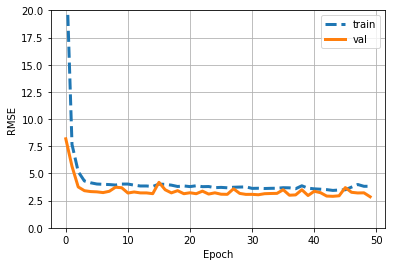

In [74]:
plot_RMSE(S_train_losses, S_valid_losses, y_max= 20)

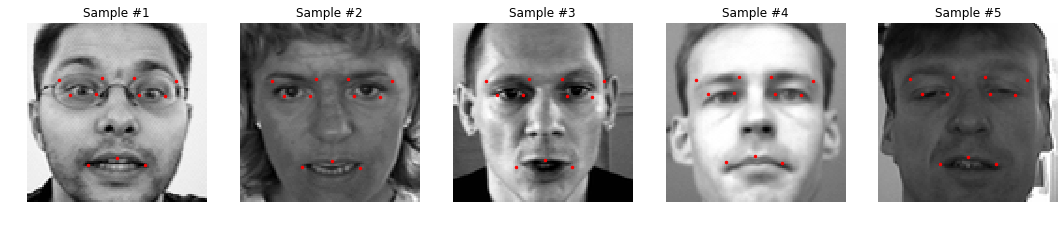

In [75]:
model.load_state_dict(torch.load('S_aug_cnn.pt'))

S_predictions = predict(test_loader, model)

S_columns = S_aug_df.drop('Image', axis=1).columns

view_pred_df(S_columns, test_df, S_predictions)

## Combine L & S model predictions

Now, we combine both predictions and submit.

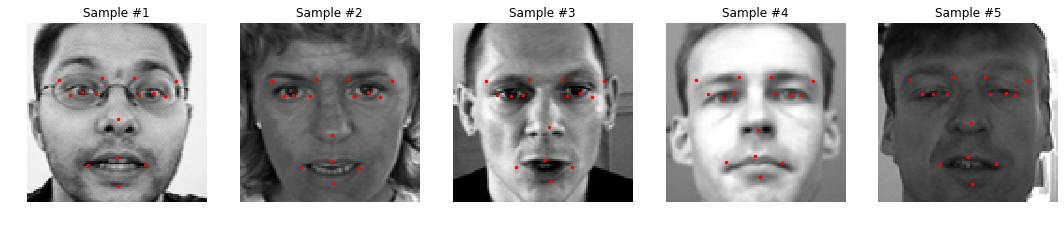

In [76]:
predictions = np.hstack((L_predictions, S_predictions))
columns = list(L_columns) + list(S_columns)
view_pred_df(columns, test_df, predictions)

In [0]:
create_submission(predictions, 
                  pred_file='data/2models_preds.csv', 
                  sub_file='data/2models_submission.csv',
                  columns=columns)

In [78]:
# Comment out to submit to Kaggle
#!kaggle competitions submit -c facial-keypoints-detection -f data/2models_submission.csv -m "L + S Models"

100% 629k/629k [00:06<00:00, 97.9kB/s]
Successfully submitted to Facial Keypoints Detection